In [75]:
# Importing standard Qiskit libraries
from qiskit import IBMQ, Aer, QuantumCircuit, QuantumRegister, transpile, execute
from qiskit.circuit.library.standard_gates import ZGate
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-04-11 06:23:10,538: Credentials are already in use. The existing account in the session will be replaced.





# Circuit

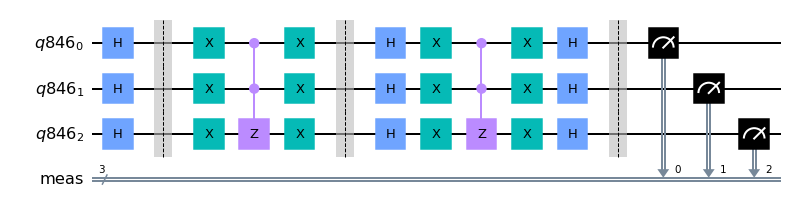

In [117]:
qr = QuantumRegister(3)
qc = QuantumCircuit(qr)

### TARGET STATE (== state to find), to be chosen from [000,100,010,001,110,101,011,111]
target = "000"
###

# Oracle for all 8 possible input target states
def oracle(target):
    target = target[::-1] # reversed to match Qiskit's qubit order

    # 001, 010, 001 <--- NOT gate on 0s, CCZ (order doesn't matter, they're all 1s at that point)
    if target.count("1") == 1:
        zeroes = [i for i, x in enumerate(target) if x == "0"]
        qc.x(zeroes)
        qc.append(ZGate().control(2), qr)
        qc.x(zeroes)
    
    # 110, 101, 011 <--- NOT gate on 0, CCZ
    elif target.count("1") == 2:
        zero = target.find("0")
        qc.x(zero)
        qc.append(ZGate().control(2), qr)
        qc.x(zero)
    
    # 111 <--- CCZ
    elif target.count("1") == 3:
        qc.append(ZGate().control(2), qr)
    
    # 000 <--- NOT on all 3, CCZ
    else:
        qc.x(qr)
        qc.append(ZGate().control(2), qr)
        qc.x(qr)

# Diffuser (performs reflection about mean)
def diffuser():
    qc.h(qr)
    qc.x(qr)
    qc.append(ZGate().control(2), qr)
    qc.x(qr)
    qc.h(qr)
        
# Initialization
qc.h(qr)
qc.barrier()

# Oracle for input state
oracle(target)
qc.barrier()

# Amplification
diffuser()

# Measurement
qc.measure_all()
qc.draw()




# Execution

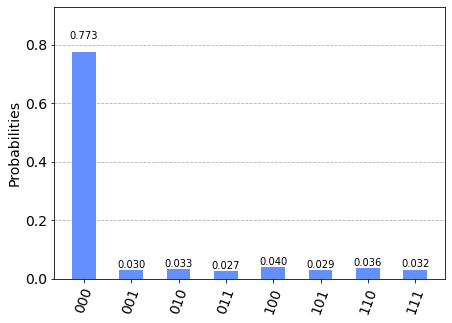

In [118]:
backend = Aer.get_backend('qasm_simulator') # the device to run on
result = execute(qc, backend, shots=1000).result()
counts = result.get_counts(qc)
plot_histogram(counts)

least busy backend:  ibmq_quito
Job Status: job has successfully run


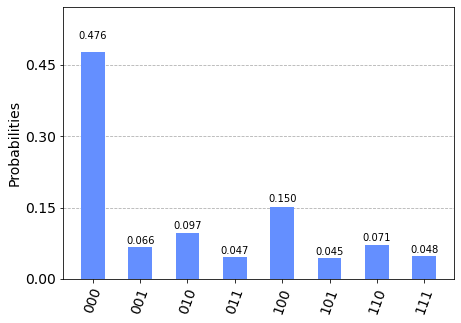

In [119]:
# Find backend
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

# Monitor execution
transpiled = transpile(qc, backend, optimization_level=3)
job = backend.run(transpiled)
job_monitor(job, interval=2)

# Run on real hardware and plot
results = job.result()
answer = results.get_counts(qc)
plot_histogram(answer)